# Эксперименты с шумом


 In-sample MSE: 5.2099510337772585
Population MSE: 5.458203725617651


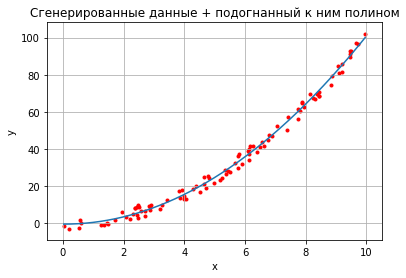

In [31]:
%matplotlib inline

# General:
import numpy as np
# Graphics:
import seaborn as sns
from matplotlib import pyplot as plt
# Mathematics:
from random import random, randint, uniform
import numpy.polynomial.polynomial as poly
# ML:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


POPULATION_SIZE = 100000
SAMPLE_SIZE = 100
POLY_DEGREE = 2
NOISE       = 4


def experiment(population_size, sample_size, poly_degree, noise_magnitude, show_result=True):
    # 1. Сгенерируем данные, порождённые параболой с некоторым шумом:
    X = [random()*10 for _ in range(population_size)]
    y = [(each**2) + uniform(-1, 1)*noise_magnitude for each in X]
    
    # 2. Вытянем выборку заданного объёма:
    _, X_sample, _, y_sample = train_test_split(X, y, test_size=sample_size)

    # 3. Произведём подгонку к данным полинома заданной степени:
    coefs = poly.polyfit(X_sample, y_sample, poly_degree)
    fit = poly.Polynomial(coefs)
    
    # 4. Отчитаемся о величине ошибки на тренировочной выборке и на популяции:
    # ----- E_in:
    y_pred = [fit(each) for each in X_sample]
    E_in = mean_squared_error(y_sample, y_pred)
    # ----- E_population:
    y_pred = [fit(each) for each in X]
    E_pop = mean_squared_error(y, y_pred)
    if show_result:
        print('\n In-sample MSE:', E_in)
        print('Population MSE:'  , E_pop)
    
    # 5. Отобразим результат графически:
    if show_result:
        x_coords = np.linspace(min(X_sample), max(X_sample), num=len(X_sample)*10)
        plt.clf()
        plt.plot(x_coords, fit(x_coords))
        plt.scatter(X_sample, y_sample, c='r', marker='.')
        plt.title('Сгенерированные данные + подогнанный к ним полином')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.show()
    return E_in, E_pop


experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

## 1. Наблюдение первое - о переподгонке и шуме
Из лекции профессора Абу-Мостафа о переподгонке следует, что виновником переподгонки является шум. При этом даже в случае отсутствия стохастического шума переподгонка очень даже возможна - при наличии детерминистского шума:

$$\mathrm{E}_{\mathcal{D}}[E_{out}(g^{\mathcal{D}}(x))] = \underbrace{ \mathrm{E}_{\mathcal{D}}[\mathrm{E}_x[(g^{\mathcal{D}}(x)-\bar{g}(x))^2]] }_{variance} \quad + \underbrace{\mathrm{E}_{\mathsf{x}}[(\bar{g}(x)-f(x))^2]}_{bias,\space детерминистский \space шум} + \underbrace{ \mathrm{E}_{\epsilon, x}[(\epsilon(x))^2] }_{noise,\space стохастический\space шум}$$

Отсюда следует, что если свести весь шум к нулю, то ошибка будет равна дисперсии модели, которую, собственно, тоже можно ограничить. 

<br><br><center>**Опыт 1. Нулевой шум, ненулевая вариативность**</center>

Введём следующие условия:

**Условия:**
1. Стохастический шум равен нулю: $\forall{x}, \epsilon(x)=0$
2. Детерминистский шум равен нулю: $Complexity(g)=Complexity(f)$
3. Вариативность модели ненулевая; в данном случае (т.е. в случае с целевой функцией-параболой) объём выборки должен быть $\lt 3$.

**Ожидание:**

- Oжидается в целом небольшая MSE, обусловленная целиком дисперсией, присущей модели.

Поскольку объём тренировочной выборки составляет менее трёх точек, нельзя определить подгоняемую параболу однозначно. В самом деле, через одну или две точки можно провести бесконечное количество парабол.

/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned



 In-sample MSE: 7.180107573918664e-33
Population MSE: 297.60258928747606


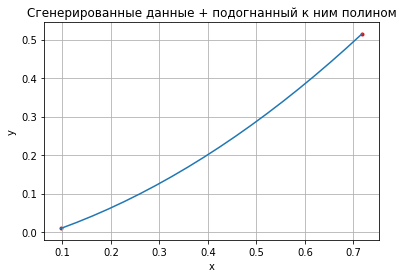

In [3]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 2 # < 3, данных для однозначного построения параболы недостаточно
POLY_DEGREE = 2 # нулевой детерминистский шум
NOISE       = 0 # нулевой стохастический  шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

Прогнав данную функцию несколько раз, мы видим, что внесэмпловая ошибка чаще всего бывает очень большая, и скачет от 3 до 330 (за несколько прогонов). Для более точного отчёта мы можем прогнать алгоритм тысячу раз и записать результаты, отчитавшись о среднем значении ошибок:

In [4]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')

/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.

/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned
/home/kos/anaconda3/lib/python3.


MSE на тренировке
	  Среднее: 2.09791457578601e-28
	Дисперсия: 1.3038934641617491e-55
	Min и max: 0.0 2.5279047707807323e-27

MSE на популяции
	  Среднее: 25.849223305925463
	Дисперсия: 1495.9491688142612
	Min и max: 3.8951957792832363 279.79040584622965 



/home/kos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RankWarning: The fit may be poorly conditioned


**Результат:**
* MSE на тренировочной выборке ожидаемо получилась практически нулевой, в силу того, что подгонка полинома второй степени к двум точкам всегда будет идеальной.
* Однако на популяции MSE ожидаемо оказалась выше, с мощной дисперсией. Это обусловлено тем, что через две точки можно провести бесконечное количество парабол, и какая из них будет ближе к целевой функции - абсолютно неизвестно.

Теперь проведём такой же опыт, но уберём вариативность, задав как минимум 3 точки для тренировочного набора. Для точного задания параболы необходимо иметь как минимум 3 точки, через которые она проходит; а в силу того, что данные не имеют шума, эти 3 точки всегда будут лежать ровно на целевой параболе. Таким образом, ожидается, что подгонка всегда будет идеальной.

<br><br><center>**Опыт 2. Нулевой шум, нулевая вариативность**</center>

**Условия:**
1. Стохастический шум равен нулю: $\forall{x}, \epsilon(x)=0$
2. Детерминистский шум равен нулю: $\mathrm{Complexity}(g)=\mathrm{Complexity}(f)$
3. Вариативность модели нулевая; в данном случае (т.е. в случае с целевой функцией-параболой) объём выборки должен быть $=3$.

**Ожидание:**

- Oжидается нулевая MSE как на тренировке, так и на популяции. Это будет достигнуто за счёт нулевой вариативности, нулевого детерминистского и нулевого стохастического шума.


 In-sample MSE: 1.0703692061695683e-27
Population MSE: 1.8819982608617712e-27


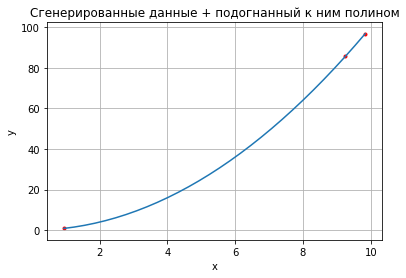

In [5]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 3 # нулевая вариативность - достаточно данных для однозначного построения параболы
POLY_DEGREE = 2 # нулевой детерминистский шум
NOISE       = 0 # нулевой стохастический  шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

Многократный прогон:

In [6]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')


MSE на тренировке
	  Среднее: 1.0850573038088285e-27
	Дисперсия: 6.359621739070053e-54
	Min и max: 2.629536350736706e-31 1.8672718768117344e-26

MSE на популяции
	  Среднее: 4.417386125110276e-25
	Дисперсия: 1.6209556775170285e-47
	Min и max: 2.022444350537338e-29 4.0460793657537543e-23 



**Результат:**
* MSE ожидаемо получилась нулевой, как на тренировочной выборке, так и на популяции.

В этом опыте мы фактически создали ситуацию, в которой для любых трёх точек, порождённых целевой функцией, наш ученик будет генерировать набор гипотез равный всего лишь одной гипотезе, которая совпадает с целевой функцией. Таким образом, симулировалась ситуация, в которой вариативность модели и её смещение равны нулю. В отсутствии шума, MSE ожидаемо получилась нулевой как на тренировке, так и на популяции.

Теперь возьмём эту ситуацию, но добавим немного стохастического шума.

<br><br><center>**Опыт 3. Ненулевой стохастический шум, ненулевая вариативность**</center>

**Условия:**
1. Стохастический шум не равен нулю: $epsilon(x) \neq 0$
2. Детерминистский шум равен нулю: $Complexity(g)=Complexity(f)$
3. Вариативность модели ненулевая. Даже при объёме обучающей выборки $>3$, парабола, подогнанная к этим трём точкам, будет отличаться от целевой функции, в силу наличия стохастического шума. По этой же причине каждый раз при генерации трёх точек варианты подогнанных парабол могут различаться. Таким образом, "средняя гипотеза" $\bar{g}(x)=\mathrm{E}_{\mathcal{D}}[g(x)]$ уже не будет единственной в наборе гипотез $\mathcal{H}$ ученика.

**Ожидание:**

- Oжидается нулевая MSE на обучающей выборке, в силу того, что можно идеально подогнать параболу к любым трём точкам. При этом энергия шума не имеет значения, однако если точек в эксперименте больше, чем 3, то MSE на обучающей выборке возрастёт.
- Ожидается высокая MSE на популяции, в силу того, что в данных присутствует шум. При этом энергия шума имеет значение (чем мощнее шум, тем больше ожидается MSE на популяции), и количество точек в эксперименте также имеет значение (чем больше точек дано, тем меньше ожидается  MSE на популяции). 



 In-sample MSE: 5.423155769759383e-27
Population MSE: 8.700352104574819


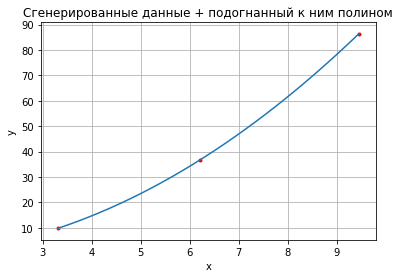

In [7]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 3 # достаточно данных для однозначного построения параболы
POLY_DEGREE = 2 # нулевой детерминистский  шум
NOISE       = 4 # ненулевой стохастический шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

Многократный прогон:

In [8]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')


MSE на тренировке
	  Среднее: 9.989773921356659e-26
	Дисперсия: 4.86453452862223e-49
	Min и max: 2.629536350736706e-31 6.864867704949535e-24

MSE на популяции
	  Среднее: 49245.474981471154
	Дисперсия: 111166478762.5661
	Min и max: 6.319157591826907 3215911.6592264445 



**Результат:**
* MSE ожидаемо получилась нулевой тренировочной выборке и очень высокой на популяции.

### Выводы по Наблюдению 1
1. Даже если нам известна форма целевой функции, не следует торопиться приближать её функцией такой же формы. Если в данных присутствует шум, подгонка может выйти очень плохой! Помочь в этом случае может лишь увеличение объёма обучающей выборки.
2. Даже если нам известна форма целевой функции и точно известно, что стохастический шум в данных отсутствует, всё равно следует сначала обратить внимание на имеющиеся у нас данные. Если их недостаточно для однозначного описания целевой функции (например, 2 точки вместо 3 в случае с параболой или 1 точка вместо 2 в случае с прямой), подгонка всё равно может выйти плохой.
3. Соответственно, даже если нам известна форма целевой функции, **при выборе ML-алгоритма мы должны руководствоваться не тем, какова сложность целевой функции (target complexity), а тем, какие ресурсы данных нам доступны (data resources we have)**, о чём и идёт речь в лекции профессора Абу-Мостафа. Отсюда и фраза "you should match the data resources you have, not target complexity!".

Мы можем ожидать, что полином 1 степени, то есть прямая, отработает лучше параболы в случае с шумной целью и не очень большим количеством точек в обучающей выборке. Это даже при том, что мы точно знаем, что целевая функция является параболой. Попробуем выполнить подгонку прямой и оценим результат:


 In-sample MSE: 14.421092813549008
Population MSE: 121.20212782427272


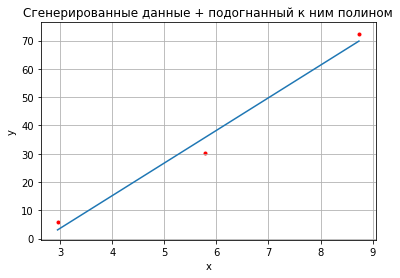

In [9]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 3 # достаточно данных для однозначного построения параболы
POLY_DEGREE = 1 # ненулевой детерминистский шум - используется прямая
NOISE       = 4 # ненулевой стохастический шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

In [10]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')


MSE на тренировке
	  Среднее: 11.521433293025396
	Дисперсия: 493.6261182097749
	Min и max: 1.6469631817347058e-06 129.54130098209677

MSE на популяции
	  Среднее: 204.87926666378033
	Дисперсия: 36260.33331725169
	Min и max: 61.39534930288234 941.147879782864 



Результат значительно улучшился: средняя MSE на популяции стала значительно меньше, и её максимум не превысил 2000, тогда как MSE при подгонке параболы исчислялась сотнями миллионов.

<br><br><hr>
## Playground

[ 0.47376816  0.09610993 -0.32754049]
[-2.54325773  1.03957113 -0.35558003]

 In-sample MSE: 1.874596464440198e-27
Population MSE: 1959.0082213305793


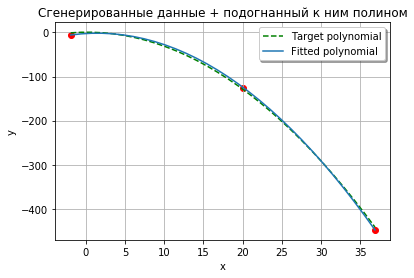

In [214]:
def experiment(target_order, fit_order, population_size, sample_size, low, hi, noise_magnitude, show_result=True):
    # 1. Сгенерируем данные, порождённые полиномом заданной степени с некоторым шумом:
    coefs = np.random.uniform(-1, 1, size=target_order+1)
    print(coefs)
    target = poly.Polynomial(coefs)
    X = np.random.uniform(low, hi, size=population_size)
    y = [target(each) + uniform(-1, 1)*noise_magnitude for each in X]
    
    # 2. Вытянем выборку заданного объёма:
    _, X_sample, _, y_sample = train_test_split(X, y, test_size=sample_size)

    # 3. Произведём подгонку к данным полинома заданной степени:
    coefs = poly.polyfit(X_sample, y_sample, fit_order)
    fit   = poly.Polynomial(coefs)
    print(coefs)
    
    # 4. Отчитаемся о величине ошибки на тренировочной выборке и на популяции:
    # ----- E_in:
    y_pred = [fit(each) for each in X_sample]
    E_in = mean_squared_error(y_sample, y_pred)
    # ----- E_population:
    y_pred = [fit(each) for each in X]
    E_pop = mean_squared_error(y, y_pred)
    if show_result:
        print('\n In-sample MSE:', E_in)
        print('Population MSE:'  , E_pop)
    
    # 5. Отобразим результат графически:
    if show_result:
        plt.clf()
        plt.title('Сгенерированные данные + подогнанный к ним полином')
        plt.xlabel('x')
        plt.ylabel('y')
        # -- Training sample points:
        x_coords = np.linspace(min(X_sample), max(X_sample), num=len(X_sample)*10)
        plt.scatter(X_sample, y_sample, c='r', marker='o')
        # -- Target polynomial:
        plt.plot(x_coords, target(x_coords), c='g', ls='--', label='Target polynomial')
        # -- Fitted polynomial:
        plt.plot(x_coords, fit(x_coords), label='Fitted polynomial')
        plt.grid() 
        plt.legend(shadow=True)
        plt.show()
    return E_in, E_pop


POPULATION_SIZE = 10000
SAMPLE_SIZE  = 3
TARGET_ORDER = 2
FIT_ORDER    = 2
NOISE        = 8
LOW, HI      = -50, 50


experiment(TARGET_ORDER, FIT_ORDER, POPULATION_SIZE, SAMPLE_SIZE, LOW, HI, NOISE);

In [57]:
np.random.uniform(-1, 1, size=10)

array([ 0.36520541,  0.83167876, -0.50091667,  0.02125   , -0.84003335,
        0.47173684, -0.18637973, -0.76392937, -0.23885455, -0.04598316])

In [ ]:
a = np.random.randint(2, size=10)


# POPULATION_SIZE = 100000
# SAMPLE_SIZE = 100
# POLY_DEGREE = 2
# NOISE       = 4


# def experiment(population_size, sample_size, poly_degree, noise_magnitude, show_result=True):
#     # 1. Сгенерируем данные, порождённые параболой с некоторым шумом:
#     X = [random()*10 for _ in range(population_size)]
#     y = [(each**2) + uniform(-1, 1)*noise_magnitude for each in X]
    
#     # 2. Вытянем выборку заданного объёма:
#     _, X_sample, _, y_sample = train_test_split(X, y, test_size=sample_size)

#     # 3. Произведём подгонку к данным полинома заданной степени:
#     coefs = poly.polyfit(X_sample, y_sample, poly_degree)
#     fit = poly.Polynomial(coefs)
    
#     # 4. Отчитаемся о величине ошибки на тренировочной выборке и на популяции:
#     # ----- E_in:
#     y_pred = [fit(each) for each in X_sample]
#     E_in = mean_squared_error(y_sample, y_pred)
#     # ----- E_population:
#     y_pred = [fit(each) for each in X]
#     E_pop = mean_squared_error(y, y_pred)
#     if show_result:
#         print('\n In-sample MSE:', E_in)
#         print('Population MSE:'  , E_pop)
    
#     # 5. Отобразим результат графически:
#     if show_result:
#         x_coords = np.linspace(min(X_sample), max(X_sample), num=len(X_sample)*10)
#         plt.clf()
#         plt.plot(x_coords, fit(x_coords))
#         plt.scatter(X_sample, y_sample, c='r', marker='.')
#         plt.title('Сгенерированные данные + подогнанный к ним полином')
#         plt.xlabel('x')
#         plt.ylabel('y')
#         plt.grid()
#         plt.show()
#     return E_in, E_pop


# experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);